In [59]:
import re
import datetime as dt 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from IPython.display import display
from tqdm import tqdm
import sqlite3 as sql 
from scipy.optimize import minimize
import scipy.stats as st 
%matplotlib inline

# db_path = '../data/options-data.db'
# conn = sql.connect(db_path)
# c = conn.cursor()
# # Get stocks (table names in db)
# stocks = [x[0] for x in c.execute("SELECT name FROM sqlite_master WHERE type='table';").fetchall()]
# # Create dict of dataframes
# lod = {}
# for stock in stocks:
#     lod[stock] = pd.read_sql(f'select * from {stock}', conn, parse_dates = ['gatherdate', 'expiry'])


# df = lod['spy'].copy()
# #contracts = df.drop(columns = ['expiry', 'strike', 'type']).set_index(['contractsymbol', 'gatherdate']).sort_index().copy()
# contracts = df.set_index(['contractsymbol', 'gatherdate']).sort_index().copy()
# # keep contracts that have atleast 10 entries 
# contracts = contracts.groupby(level = 0).filter(lambda x: len(x) > 10)
# contracts

type     expiry  strike  stk_price  \
contractsymbol     gatherdate                                                
SPY230317C00150000 2021-09-14 00:00:00  Call 2023-03-17   150.0     444.17   
                   2021-09-15 00:00:00  Call 2023-03-17   150.0     447.88   
                   2021-09-16 00:00:00  Call 2023-03-17   150.0     447.17   
                   2021-09-21 00:00:00  Call 2023-03-17   150.0     433.63   
                   2021-09-22 00:00:00  Call 2023-03-17   150.0     437.86   
...                                      ...        ...     ...        ...   
SPY230317P00720000 2023-03-17 10:02:16   Put 2023-03-17   720.0     393.83   
                   2023-03-17 12:44:33   Put 2023-03-17   720.0     390.67   
                   2023-03-17 14:32:15   Put 2023-03-17   720.0     389.33   
                   2023-03-17 15:50:57   Put 2023-03-17   720.0     389.86   
                   2023-03-17 16:00:03   Put 2023-03-17   720.0     390.02   

                                        impliedvolatility  lastprice     ask  \
contractsymbol     gatherdate                                                  
SPY230317C00150000 2021-09-14 00:00:00           0.516912     277.00  297.00   
                   2021-09-15 00:00:00           0.491094     277.00  297.50   
                   2021-09-16 00:00:00           0.490606     277.00  298.00   
                   2021-09-21 00:00:00           0.473943     285.04  285.50   
                   2021-09-22 00:00:00           0.507390     285.04  291.00   
...                                                   ...        ...     ...   
SPY230317P00720000 2023-03-17 10:02:16           5.167972     329.82  327.34   
                   2023-03-17 12:44:33           4.417973     329.82  329.56   
                   2023-03-17 14:32:15           0.000010     329.82  330.21   
                   2023-03-17 15:50:57           3.859375     329.82  330.25   
                   2023-03-17 16:00:03           3.500001     329.82  329.94   

                                           bid  timevalue inthemoney  
contractsymbol     gatherdate                                         
SPY230317C00150000 2021-09-14 00:00:00  292.00   2.178571          1  
                   2021-09-15 00:00:00  293.00   2.174603          1  
                   2021-09-16 00:00:00  293.50   2.170635          1  
                   2021-09-21 00:00:00  280.50   2.150794          1  
                   2021-09-22 00:00:00  286.50   2.146825          1  
...                                        ...        ...        ...  
SPY230317P00720000 2023-03-17 10:02:16  326.33  -0.001660          1  
                   2023-03-17 12:44:33  329.41  -0.002107          1  
                   2023-03-17 14:32:15  330.06  -0.002404          1  
                   2023-03-17 15:50:57  330.10  -0.002621          1  
                   2023-03-17 16:00:03  329.78  -0.002646          1  

[160744 rows x 10 columns]

In [71]:
# # find contract with the most entries
# c = contracts.index.get_level_values(0)
# # choose a random contract
# contract = c[np.random.randint(0, len(c))]
# # get the data for that contract
# contract_data = contracts.loc[contract].copy()

import yfinance as yf 
tick = yf.Ticker('spy')
hist = tick.history(period = 'max')['Close']

# Least Squares Monte Carlo (LSMC) Simulation Example:

Least Squares Monte carlo (LSMC) is a Monte Carlo Method for pricing financial derivatives using a combination of Monte Carlo Simulation and regression techniques. The idea is to simulate the future the stock price using a stochastic model such as geometric brownian model; then use a regression algorithim such as OLS to fit a function to the simulated stock price. 

The regression function is used to find the coefficients of a *basis* function which is then used to approximate the expected payoff. The basis function should be flexible enough to be able to approximate the expected payoff for a given option. Thus, it needs to be able to take in account highly volatile option prices, while also being simple enough to avoid overfitting.

**In this example** We will use a stock price to show the use of the Basis Function is used to approximate the price function $f(x)$. below, we use a series of polynomial basis functions to approximate the price of the option. We start with a constant value of 1, then increase the order of the $x$ values until we reach the desired order; in this case we set the order to 3 (4-1). Higher order polynomials tend to give better approximations; and should be used if the observed data is volatilie in nature. In cases where we expect the observed data to be linear, we might use a linear basis function. 

In General, choosing a basis function will be tailored to the specific problem at hand, and how you expect the observed values to behave. We can even use a basis function that is not a polynomial, such as the Normal Distribution, or more complex functions such as the Fourier Series.

The coefficients from the basis function are chosen to minimize the sum of squared errors between the predicted and actual values of the option price. Hence, the term "Least Squares" in the name of the method. The "Monte Carlo" part refers to the use of random sampling to simulate the underlying asset price paths. 

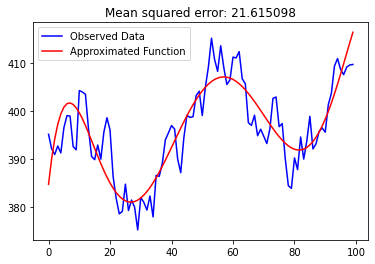

In [98]:
import numpy as np
import matplotlib.pyplot as plt

# Define the observed data
observed_data = hist.values[-100:]

# Set the number of iterations for the simulation
num_iterations = 1000

# Set the range for the input values of the function
x_min = 0
x_max = len(observed_data) - 1

# Generate a set of random input values for the function
x_values = np.random.randint(low=x_min, high=x_max, size=num_iterations)

# Calculate the output values for the observed data at the input values
y_values = observed_data[x_values]

# Define a set of basis functions to approximate the function
def basis_functions(x):
    return np.array([x**i for i in range(7)])

# Calculate the design matrix for the basis functions
X = np.stack([basis_functions(x_values[i]) for i in range(len(x_values))])

# Calculate the coefficients for the basis functions using least squares
coefficients = np.linalg.lstsq(X, y_values, rcond=None)[0]

# Define a new set of input values to test the approximation
x_test = np.linspace(x_min, x_max, num=100)

# Calculate the output values for the approximated function at the test input values
y_test = np.dot(np.stack([basis_functions(x_test[i]) for i in range(len(x_test))]), coefficients)

# get the approximated values for the observed data
ytmp = np.dot(np.stack([basis_functions(x_test[i]) for i in range(len(x_test))]), coefficients)

# Calculate the mean squared error between the observed data and the approximated function
mse = np.mean((observed_data - ytmp)**2)

# Plot the original function and the approximated function
plt.plot(np.arange(len(observed_data)), observed_data, 'b', label='Observed Data')
plt.plot(x_test, y_test, 'r', label='Approximated Function')
plt.title(f'Mean squared error: {mse:.6f}')
plt.legend(loc='best')
plt.show()


Now, Use Normal Distribution as the basis function to approximate the expected payoff of a randomly chosen option:

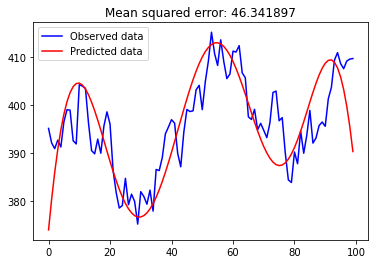

In [95]:
import numpy as np
import matplotlib.pyplot as plt

# Define the basis function
def gaussian_basis(x, mu, sigma):
    return (1/np.sqrt(2*np.pi*sigma))*np.exp(-(x - mu)**2 / (2 * sigma**2))

# Define the number of basis functions to use
num_basis_functions = 6

# Generate the data
x = np.arange(len(observed_data)) 
y = np.array(observed_data)

# Create the design matrix
design_matrix = np.zeros((len(x), num_basis_functions))
for i in range(num_basis_functions):
    mu = np.linspace(x.min(), x.max(), num_basis_functions)[i]
    sigma = (x.max() - x.min()) / num_basis_functions
    design_matrix[:, i] = gaussian_basis(x, mu, sigma)

# Compute the coefficients using least squares
coefficients = np.linalg.lstsq(design_matrix, y, rcond=None)[0]

# Compute the predicted values
y_pred = np.dot(design_matrix, coefficients)

# Calculate the mean squared error
mse = np.mean((y - y_pred)**2)

# Plot the data and the fit
lastn = 100
plt.plot(x[-lastn:], y[-lastn:], label='Observed data', color='blue')
plt.plot(x[-lastn:], y_pred[-lastn:], label='Predicted data', color='red')
plt.title(f'Mean squared error: {mse:.6f}')
plt.legend()
plt.show()




In [99]:
# What does Polynomial.fit do?
# https://numpy.org/doc/stable/reference/generated/numpy.polynomial.polynomial.Polynomial.fit.html
X = np.array([1, 2, 3, 4, 5])
Y = np.random.rand(5)
fit = np.polynomial.Polynomial.fit(X, Y, 2) # degree 2 polynomial
#plt.plot(X, Y, '-')
#plt.plot(X, fit(X), '--')

# now lets try a gaussian fit 

np.polynomial

<module 'numpy.polynomial' from '/Users/jerald/miniforge3/envs/dsenv/lib/python3.9/site-packages/numpy/polynomial/__init__.py'>

The choice of the number of basis functions used, and the parameters within those functions have a significant impact on the quality of the fit. In general, the more basis functions used, the better the fit. However, the more basis functions used, the more complex the problem becomes, and the more difficult it is to find the optimal parameters.

### Next We work on Combining the Geometric Brownian Motion and Least Squares Monte Carlo Methods to Price Options 

1. Generate a series of stock price paths using the Geometric Brownian Motion model.
2. Calculate the option price at expiration for each path. 
3. Fit Basis Function to the payoffs using OLS.
4. Calculate the expected payoff based on the fitted function and use it to calculate the option price. 